In [1]:
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, HernquistPotential
from galpy.actionAngle import estimateDeltaStaeckel, actionAngleStaeckel
from galpy.actionAngle import UnboundError

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

import numpy as np
from scipy import stats
from IPython.display import Image, display

import corner

import datetime
import random

import copy

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Circle
from matplotlib import animation
from matplotlib.colors import LogNorm


import datetime

cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))

%matplotlib inline

In [2]:
# Simulation relevant stuff
machine = 'mac'
machine = 'magny'

if machine == 'magny':
    filedir = "/home/extmilan/masterthesis/files/"
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac':
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
    plotdir = "/Users/smilanov/Documents/masterthesis/auriga_files/plots/"
else:
    raise NotADirectoryError
    
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4

for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"

    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
        

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [3]:
"""
Snapshot =  127
v0_tot_kms at R0_kpc = 8.02852213383 : 220.724646624
Stellar Disk - a_MND_kpc = 2.96507719743 b_MND_kpc = 1.63627757204 v0_MND_kms = 105.005287928
Stellar Spheroid - a_HB_kp c= 1.71545528287 v0_HB_kms = 111.241910552
DM Halo - a_NFWH_kpc = 26.0152749345 v0_NFWH_kms = 159.117869741
"""

fix_v0_kms      = 220.724646624
fix_R0_kpc      = 8.02852213383
fix_a_MND_kpc   = 2.96507719743
fix_b_MND_kpc   = 1.63627757204
fix_v0_MND_kms  = 105.005287928
fix_a_HB_kpc    = 1.71545528287
fix_v0_HB_kms   = 111.241910552
fix_v0_NFWH_kms = 159.117869741
init_a_NFWH_kpc = 26.0152749345

fix_n_MND       = fix_v0_MND_kms**2  / fix_v0_kms**2
fix_n_HB        = fix_v0_HB_kms**2   / fix_v0_kms**2
fix_n_NFWH      = fix_v0_NFWH_kms**2 / fix_v0_kms**2

#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc  / _REFR0_kpc
    b_MND  = b_MND_kpc  / _REFR0_kpc
    a_NFWH = a_NFWH_kpc / _REFR0_kpc
    a_HB   = a_HB_kpc   / _REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a = a_MND,
                b = b_MND,
                normalize = n_MND)
    halo = NFWPotential(
                a = a_NFWH,
                normalize = n_NFWH)
    bulge = HernquistPotential(
                a = a_HB,
                normalize = n_HB) 
     
    return [disk,halo,bulge]


#for a in range(50):
    

In [4]:
# load GC IDs & create their mask
IDs = np.loadtxt(filedir + 'surviving_ids_snapshot_73_sh_1.txt')
gcmask = np.isin(s.id, IDs)


In [38]:
### for "true" a_NFWH
# set up galpy potential with values of potential fitting (either smoothed or not, depends on commenting out or not)
pot_galpy = setup_galpy_potential(fix_a_MND_kpc, fix_b_MND_kpc, init_a_NFWH_kpc, fix_a_HB_kpc, fix_n_MND, fix_n_NFWH, fix_n_HB, fix_R0_kpc)

# this would mean that there are no merged GCs
if np.sum(gcmask) == 0:
    print("skipped this step")
    #continue

# get position and velocities of all selected GCs & convert to galpy units
(R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
# convert physical to galpy units by dividing by REF vals (get velocities from best fit parameters)
R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / fix_R0_kpc, vR_kms / fix_v0_kms, vphi_kms / fix_v0_kms, z_kpc / fix_R0_kpc, vz_kms / fix_v0_kms

# estimate Delta of the Staeckel potential
delta = 0.45
delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)
# CHECK HOW BIG INFLUENCE OF DELTA IS


# set up the actionAngleStaeckel object
aAS = actionAngleStaeckel(
        pot   = pot_galpy,  # potential
        delta = delta,      # focal length of confocal coordinate system
        c     = True        # use C code (for speed)
        )


jR_galpy, lz_galpy, jz_galpy, r_kpc = np.zeros(len(IDs)), np.zeros(len(IDs)), np.zeros(len(IDs)), np.zeros(len(IDs))
savedIDs = np.zeros(len(IDs))
IDs_notworking = []
for test_i, item in enumerate(IDs):
    if (test_i % 1000) == 0:
        print(datetime.datetime.now().time())
        print(test_i)
    try: 
        jR_galpy[test_i], lz_galpy[test_i], jz_galpy[test_i] = aAS(R_galpy[test_i], vR_galpy[test_i], vT_galpy[test_i], z_galpy[test_i], vz_galpy[test_i])
        r_kpc[test_i] = np.sqrt(R_kpc[test_i]**2 + z_kpc[test_i]**2)
        savedIDs[test_i] = item
    except(ValueError, UnboundError):
        IDs_notworking.append(item)
        continue
print('numbers of GCs wo actions:', len(IDs_notworking))
jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * fix_R0_kpc * fix_v0_kms, lz_galpy * fix_R0_kpc * fix_v0_kms, jz_galpy * fix_R0_kpc * fix_v0_kms

# just pick result values of particles of which I actually could calculate actions
survivor_id_mask = np.isin(IDs, savedIDs)
jR_kpckms, lz_kpckms, jz_kpckms = jR_kpckms[survivor_id_mask], lz_kpckms[survivor_id_mask], jz_kpckms[survivor_id_mask]
r_kpc = r_kpc[survivor_id_mask]
survivor_IDs = IDs[survivor_id_mask]
init_jR_kpckms = jR_kpckms
init_jz_kpckms = jz_kpckms

14:51:26.513531
0
14:52:12.599995
1000
14:52:58.660314
2000
14:53:44.729954
3000
14:54:30.861739
4000
14:55:16.965173
5000
14:56:03.037627
6000
14:56:49.146826
7000
14:57:35.326197
8000
14:58:21.470122
9000
numbers of GCs wo actions: 0


In [6]:
init_mean_jR_kpckms = np.mean(jR_kpckms)
init_std_jR_kpckms  = np.std(jR_kpckms)
init_skew_jR_kpckms = stats.skew(jR_kpckms)
init_mean_jz_kpckms = np.mean(jz_kpckms)
init_std_jz_kpckms  = np.std(jz_kpckms)
init_skew_jz_kpckms = stats.skew(jz_kpckms)
init_cov_jR_jz = np.cov(jR_kpckms, jz_kpckms)

In [9]:
covs = []


In [ ]:
### for "false" a_NFWH
#N = 50

a_NFWH_arr = np.arange(10,41,1)
mean_jR_kpckms = []
std_jR_kpckms  = []
skew_jR_kpckms = []
mean_jz_kpckms = []
std_jz_kpckms  = []
skew_jz_kpckms = []
covs_jR_jz = []
for var_a_NFW_kpc in a_NFWH_arr:
    print(var_a_NFW_kpc)
    # set up galpy potential with values of potential fitting (either smoothed or not, depends on commenting out or not)
    try:
        pot_galpy = setup_galpy_potential(fix_a_MND_kpc, fix_b_MND_kpc, var_a_NFW_kpc, fix_a_HB_kpc, fix_n_MND, fix_n_NFWH, fix_n_HB, fix_R0_kpc)
    except:
        mean_jR_kpckms.append(-99.)
        std_jR_kpckms.append(-99.)
        mean_lz_kpckms.append(-99.)
        std_lz_kpckms.append(-99.)
        mean_jz_kpckms.append(-99.)
        std_jz_kpckms.append(-99.)
        print('For a_NFW = {:d} no potential can be set up.'.format(var_a_NFW_kpc) )
        continue
    # this would mean that there are no merged GCs
    if np.sum(gcmask) == 0:
        print("skipped this step")
        #continue

    # get position and velocities of all selected GCs & convert to galpy units
    (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
    # convert physical to galpy units by dividing by REF vals (get velocities from best fit parameters)
    R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / fix_R0_kpc, vR_kms / fix_v0_kms, vphi_kms / fix_v0_kms, z_kpc / fix_R0_kpc, vz_kms / fix_v0_kms

    # estimate Delta of the Staeckel potential
    delta = 0.45
    delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)
    # CHECK HOW BIG INFLUENCE OF DELTA IS


    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = pot_galpy,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )


    jR_galpy, lz_galpy, jz_galpy, r_kpc = np.zeros(len(IDs)), np.zeros(len(IDs)), np.zeros(len(IDs)), np.zeros(len(IDs))
    savedIDs = np.zeros(len(IDs))
    IDs_notworking = []
    try:
        print(datetime.datetime.now().time())
        jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy)
        r_kpc = np.sqrt(R_kpc**2 + z_kpc**2)
        saveIDs = IDs
    except:
        for test_i, item in enumerate(IDs):
            if (test_i % 1000) == 0:
                print(datetime.datetime.now().time())
                print(test_i)
            try: 
                jR_galpy[test_i], lz_galpy[test_i], jz_galpy[test_i] = aAS(R_galpy[test_i], vR_galpy[test_i], vT_galpy[test_i], z_galpy[test_i], vz_galpy[test_i])
                r_kpc[test_i] = np.sqrt(R_kpc[test_i]**2 + z_kpc[test_i]**2)
                savedIDs[test_i] = item
            except(ValueError, UnboundError):
                IDs_notworking.append(item)
                continue
        print('numbers of GCs wo actions:', len(IDs_notworking))
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * fix_R0_kpc * fix_v0_kms, lz_galpy * fix_R0_kpc * fix_v0_kms, jz_galpy * fix_R0_kpc * fix_v0_kms

    # just pick result values of particles of which I actually could calculate actions
    survivor_id_mask = np.isin(IDs, savedIDs)
    jR_kpckms, lz_kpckms, jz_kpckms = jR_kpckms[survivor_id_mask], lz_kpckms[survivor_id_mask], jz_kpckms[survivor_id_mask]
    r_kpc = r_kpc[survivor_id_mask]
    survivor_IDs = IDs[survivor_id_mask]

    mean_jR_kpckms.append(np.mean(jR_kpckms))
    std_jR_kpckms.append(np.std(jR_kpckms))
    skew_jR_kpckms.append(stats.skew(jR_kpckms))
    mean_jz_kpckms.append(np.mean(jz_kpckms))
    std_jz_kpckms.append(np.std(jz_kpckms))
    skew_jz_kpckms.append(stats.skew(jz_kpckms))
    cov_jR_jz = np.cov(jR_kpckms, jz_kpckms)
    covs_jR_jz.append(cov_jR_jz)

10
10:27:48.085803
0
10:28:34.031510
1000
10:29:19.993190
2000
10:30:05.560462
3000
10:30:51.543714
4000
10:31:37.507321
5000
10:32:23.133181
6000
10:33:09.000488
7000
10:33:54.925328
8000
10:34:40.679889
9000
numbers of GCs wo actions: 4
11
10:35:25.178950
0
10:36:11.169671
1000
10:36:56.965011
2000
10:37:42.934401
3000
10:38:28.673055
4000
10:39:14.722946
5000
10:40:00.467782
6000
10:40:46.472531
7000
10:41:32.241407
8000
10:42:18.332570
9000
numbers of GCs wo actions: 1
12
10:43:02.845748
0
10:43:48.741121
1000
10:44:35.229909
2000
10:45:21.706130
3000
10:46:07.954223
4000
10:46:54.149829
5000
10:47:40.454020
6000
10:48:26.428022
7000
10:49:12.592123
8000
10:49:58.852787
9000
numbers of GCs wo actions: 0
13
10:50:43.740036
0
10:51:30.055116
1000
10:52:16.181928
2000
10:53:02.480626
3000
10:53:48.580655
4000
10:54:34.778132
5000
10:55:20.882838
6000
10:56:07.181000
7000
10:56:53.174335
8000
10:57:39.503739
9000
numbers of GCs wo actions: 0
14
10:58:24.216168
0
10:59:10.374036
1000
10

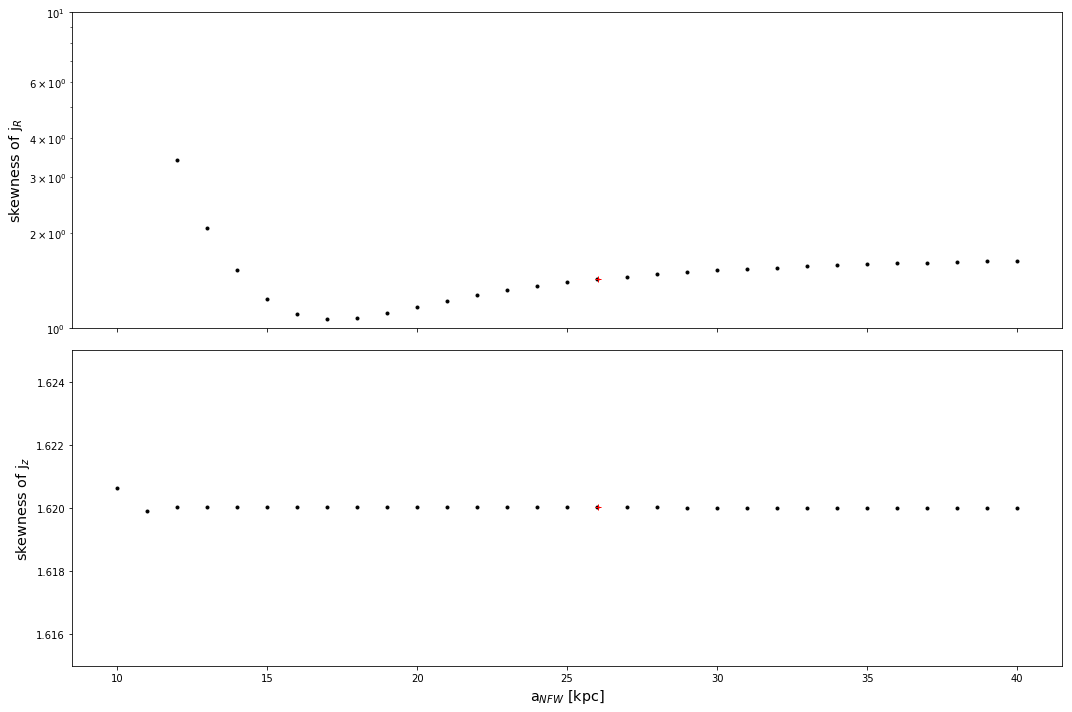

In [52]:
# goal plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (15,10))

ax1.plot(a_NFWH_arr, np.array(skew_jR_kpckms), 'k.')
ax1.plot(init_a_NFWH_kpc, init_skew_jR_kpckms, marker = '+', color = 'red')
#ax1.xlabel('a$_{NFW}$')
ax1.set_yscale("log", nonposy='clip')
#ax1.hlines(init_mean_jR_kpckms, 0, np.max(a_NFWH_arr)+1, color = 'red', alpha = 0.5)
ax1.set_ylim(1, 10)

ax1.set_ylabel('skewness of j$_R$', size = 'x-large')
#plt.show()


ax2.plot(a_NFWH_arr, skew_jz_kpckms, 'k.')
ax2.plot(init_a_NFWH_kpc, init_skew_jz_kpckms, marker = '+', color = 'red')
#ax2.hlines(init_mean_jz_kpckms, 0, np.max(a_NFWH_arr)+1, color = 'red', alpha = 0.5)

ax2.set_xlabel('a$_{NFW}$ [kpc]', size = 'x-large')
#ax2.set_yscale("log", nonposy='clip')
ax2.set_ylim(1.615, 1.625)
ax2.set_ylabel('skewness of j$_z$', size = 'x-large')
#plt.show()

fig.tight_layout()

fig.savefig(plotdir + 'a_NFW_diagnostic_plot_skewness.png', dpi = 300, format = 'png')

In [26]:
print(np.min(skew_jz_kpckms), np.max(skew_jz_kpckms))

1.61990586114 1.62064572427


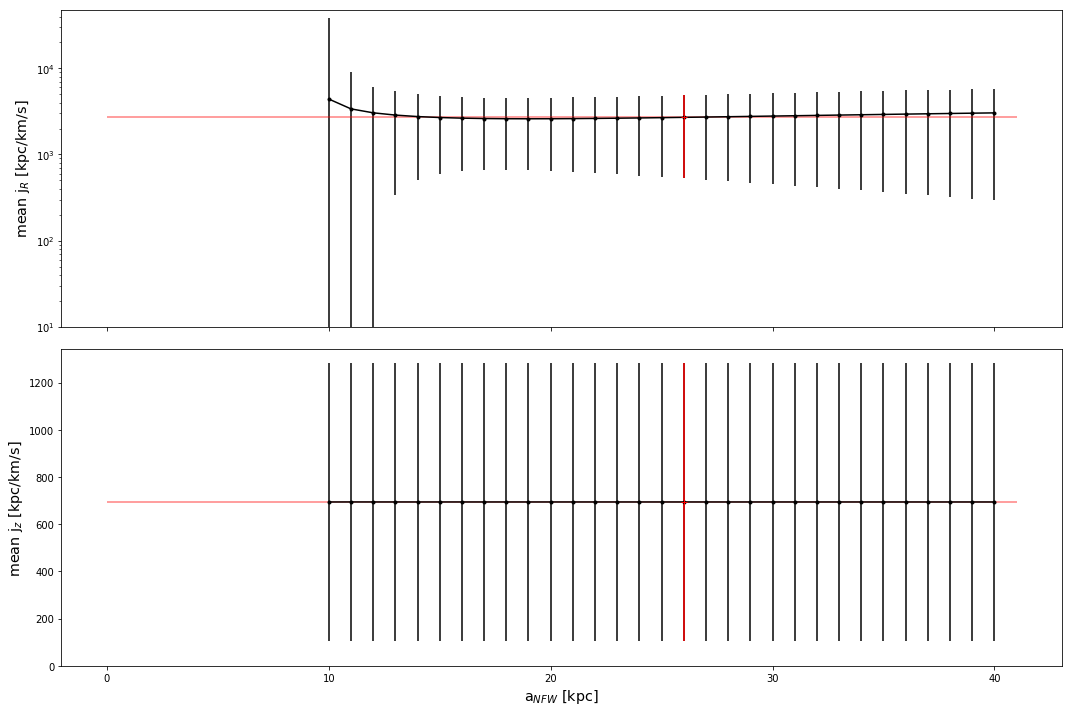

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (15,10))

ax1.errorbar(a_NFWH_arr, np.array(mean_jR_kpckms), yerr = np.array(std_jR_kpckms), marker = '.', color = 'black')
ax1.errorbar(init_a_NFWH_kpc, init_mean_jR_kpckms, init_std_jR_kpckms, marker = '+', color = 'red')
#ax1.xlabel('a$_{NFW}$')
ax1.set_yscale("log", nonposy='clip')
ax1.hlines(init_mean_jR_kpckms, 0, np.max(a_NFWH_arr)+1, color = 'red', alpha = 0.5)
ax1.set_ylim(10, None)

ax1.set_ylabel('mean j$_R$ [kpc/km/s]', size = 'x-large')
#plt.show()


ax2.errorbar(a_NFWH_arr, mean_jz_kpckms, yerr = std_jz_kpckms, marker = '.', color = 'black')
ax2.errorbar(init_a_NFWH_kpc, init_mean_jz_kpckms, init_std_jz_kpckms, marker = '+', color = 'red')
ax2.hlines(init_mean_jz_kpckms, 0, np.max(a_NFWH_arr)+1, color = 'red', alpha = 0.5)

ax2.set_xlabel('a$_{NFW}$ [kpc]', size = 'x-large')
#ax2.set_yscale("log", nonposy='clip')
ax2.set_ylim(0, None)
ax2.set_ylabel('mean j$_z$ [kpc/km/s]', size = 'x-large')
#plt.show()

fig.tight_layout()

fig.savefig(plotdir + 'a_NFW_diagnostic_plot_mean_std.png', dpi = 300, format = 'png')

In [21]:
covs_jR_jz

[array([[  1.16410066e+09,   1.05451944e+06],
        [  1.05451944e+06,   3.47163495e+05]]),
 array([[ 31735717.45732604,    262917.68979572],
        [   262917.68979572,    347178.23529179]]),
 array([[ 9488808.157849  ,   210502.39428181],
        [  210502.39428181,   347157.87653292]]),
 array([[ 6420889.91936148,   204502.08657514],
        [  204502.08657514,   347155.20428734]]),
 array([[ 5063613.18804655,   204583.56548807],
        [  204583.56548807,   347151.94805796]]),
 array([[ 4365333.10090863,   207698.91020403],
        [  207698.91020403,   347148.15112164]]),
 array([[ 3997201.05191958,   212553.01503229],
        [  212553.01503229,   347145.05737579]]),
 array([[ 3816961.0477395 ,   218475.03474396],
        [  218475.03474396,   347141.49792098]]),
 array([[ 3752700.30407628,   225074.00017409],
        [  225074.00017409,   347138.30203403]]),
 array([[ 3764281.13684101,   232106.89640854],
        [  232106.89640854,   347134.77109798]]),
 array([[ 3827655.40

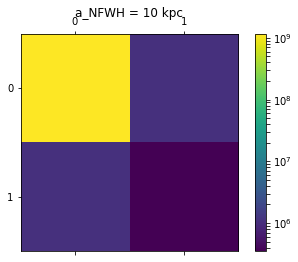

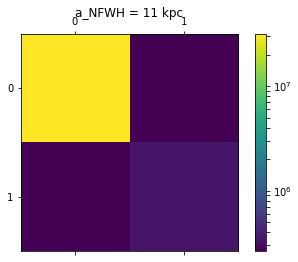

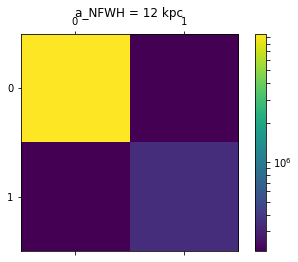

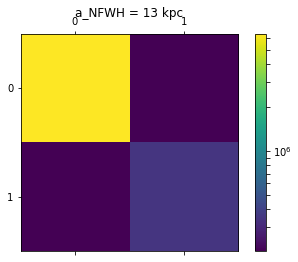

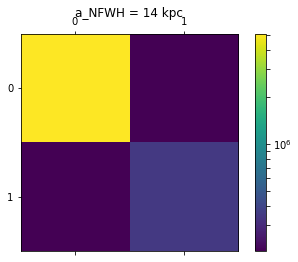

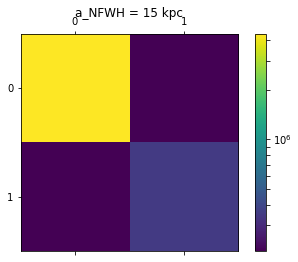

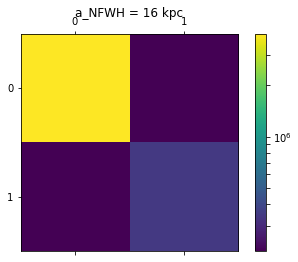

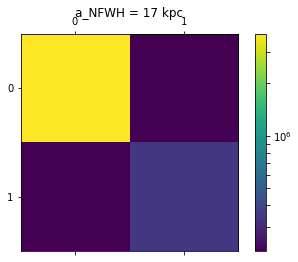

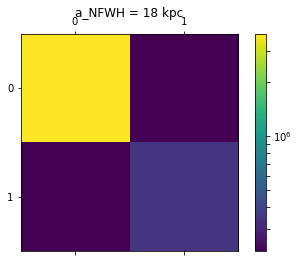

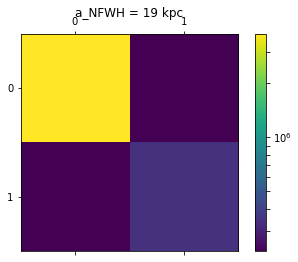

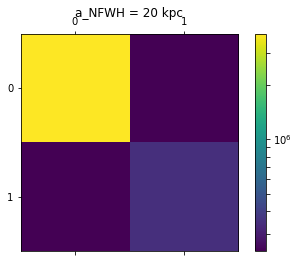

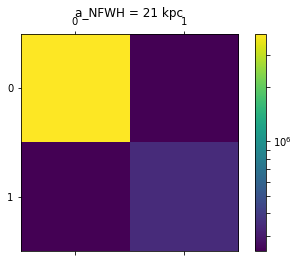

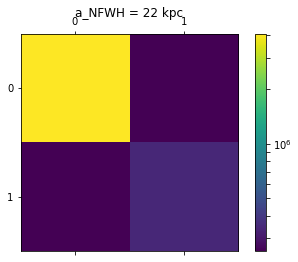

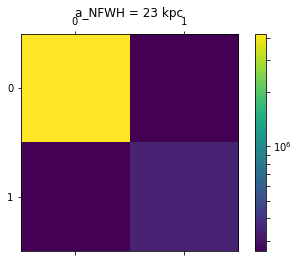

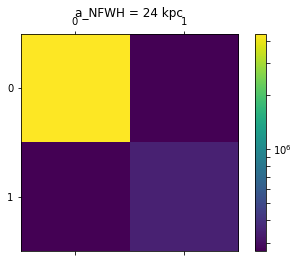

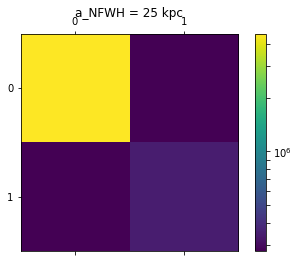

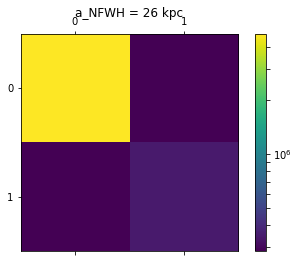

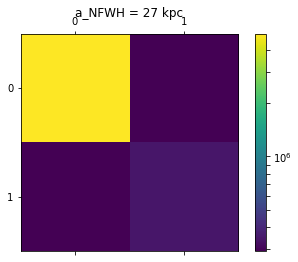

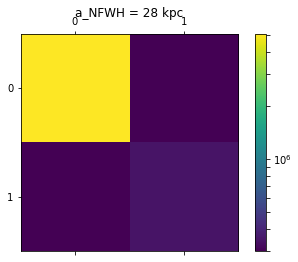

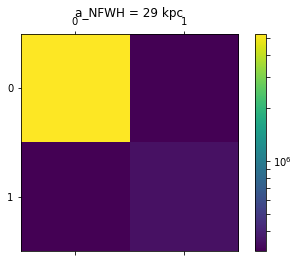

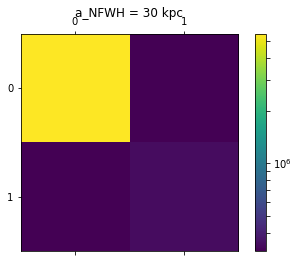

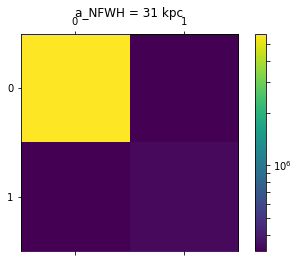

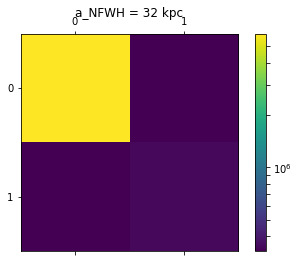

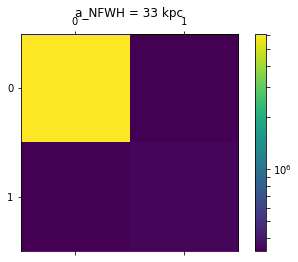

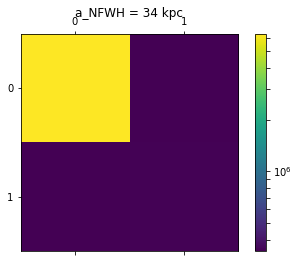

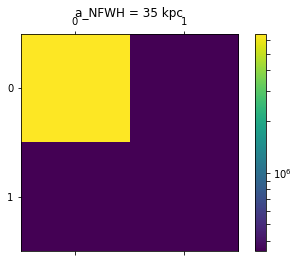

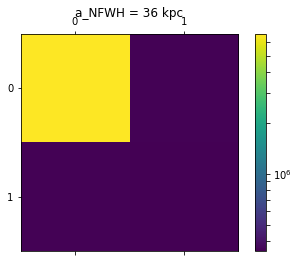

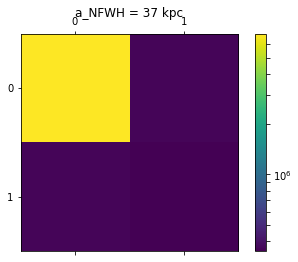

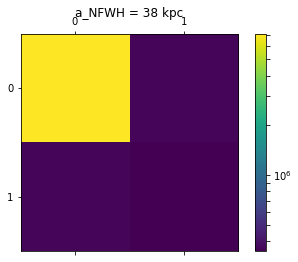

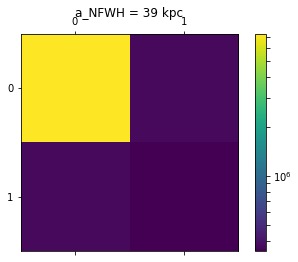

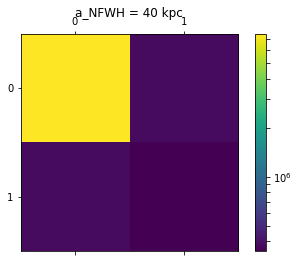

In [37]:
# try to show covariance matrix
for i in range(len(covs_jR_jz)):
    # plot correlation matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(covs_jR_jz[i], norm = LogNorm())
    fig.colorbar(cax)
    ax.set_title('a_NFWH = {} kpc'.format(a_NFWH_arr[i]))
    plt.show()

In [ ]:
from matplotlib.patches import Ellipse

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]


nstd = 2
ax = plt.subplot(111)

#cov = np.cov(x, y)
vals, vecs = eigsorted(covs_jR_jz[-1])
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
w, h = 2 * nstd * np.sqrt(vals)
ell = Ellipse(xy=(mean_jR_kpckms[-1], mean_jz_kpckms[-1]),
              width=w, height=h,
              angle=theta, color='black')
ell.set_facecolor('none')
ax.add_artist(ell)
plt.hist2d(jR_kpckms, jz_kpckms, bins = 41)
plt.xlabel('jR [kpc/km/s]')
plt.ylabel('jz [kpc/km/s]')
plt.title('a_NFWH = {} kpc'.format(a_NFWH_arr[-1]))
plt.show()

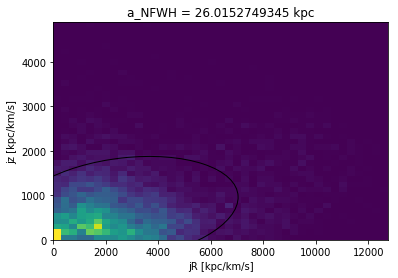

In [40]:
nstd = 2
ax = plt.subplot(111)

#cov = np.cov(x, y)
vals, vecs = eigsorted(init_cov_jR_jz)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
w, h = 2 * nstd * np.sqrt(vals)
ell = Ellipse(xy=(init_mean_jR_kpckms, init_mean_jz_kpckms),
              width=w, height=h,
              angle=theta, color='black')
ell.set_facecolor('none')
ax.add_artist(ell)
plt.hist2d(init_jR_kpckms, init_jz_kpckms, bins = 41)
plt.xlabel('jR [kpc/km/s]')
plt.ylabel('jz [kpc/km/s]')
plt.title('a_NFWH = {} kpc'.format(init_a_NFWH_kpc))
plt.show()

In [41]:
# calculate concentration
M200 = sf.data['fmc2'][0] #M200
R200 = sf.data['frc2'][0] #R200
a = init_a_NFWH_kpc
c = a/R200

In [43]:
c 

108.01188770424625